In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import tifffile
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.neighbors import NearestNeighbors
from autobl.steering import configs, measurement
from autobl import image_proc
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

In [2]:
# Load the image and initialize the probe
image = tifffile.imread(os.path.join("tests", "data", "xrf", "ground_609_full.tiff"))  # Load the XRF image data
probe = np.ones((4, 4))  # Initialize a 4x4 probe with all ones (a simple uniform probe)

# Set up the experiment parameters   
sample_params = configs.SpatialSampleParams(image=image, psize_nm=1)  # Define spatial sample parameters, including the image and pixel size

setup_params = configs.FlyScanExperimentSetupParams(
    psize_nm=1.0,  # Pixel size in nanometers
    scan_speed_nm_sec=1.0,  # Scanning speed in nanometers per second
    exposure_sec=0.2,  # Exposure time in seconds
    deadtime_sec=0.05,  # Dead time between scans in seconds
    probe=probe,  # Use the initialized probe for the experiment
)

measurement_configs = configs.FlyScanSimulationConfig(
    sample_params=sample_params,  # Use the defined spatial sample parameters
    setup_params=setup_params,  # Use the defined experimental setup parameters
    step_size_for_integration_nm=0.02,  # Step size for integration in nanometers
)

# Initialize the measurement interface for the FlyScan simulation
measurement_interface = measurement.FlyScanSingleValueSimulationMeasurement(measurement_configs)

# Initialize the reconstructor with Inverse Distance Weighting (IDW) method, using PyTorch as the backend
reconstructor = image_proc.Reconstructor("idw", backend="torch")

In [3]:
# Define the distortion function
def calculate_distortion(image, reconstruction):
    return 0.5 * (image - reconstruction) ** 2

In [4]:
# whole image grid points
y_dense = torch.arange(0.0, image.shape[0], 1)
x_dense = torch.arange(0.0, image.shape[1], 1)
meshgrids_dense = torch.meshgrid(y_dense, x_dense, indexing='ij')
xi = torch.stack(meshgrids_dense, dim=-1).reshape(-1, len(meshgrids_dense))

# Define image dimensions and margins
height = image.shape[0]
width = image.shape[1]
margin = 10  # Adjust as needed

# Define start and end coordinates for the 'Z'-shaped path
x_start = margin
x_end = width - margin
y_start = margin
y_end = height - margin

# Number of points along each segment of the 'Z'
num_points_per_segment = 50  # Adjust as needed

# First segment: top horizontal line from left to right
x1 = torch.linspace(x_start, x_end, num_points_per_segment)
y1 = torch.full_like(x1, y_start)

# Second segment: diagonal line from top-right to bottom-left
x2 = torch.linspace(x_end, x_start, num_points_per_segment)
y2 = torch.linspace(y_start, y_end, num_points_per_segment)

# Third segment: bottom horizontal line from left to right
x3 = torch.linspace(x_start, x_end, num_points_per_segment)
y3 = torch.full_like(x3, y_end)

# Exclude the first point of the subsequent segments to avoid duplicates
x_coords = torch.cat([x1, x2[1:], x3[1:]])
y_coords = torch.cat([y1, y2[1:], y3[1:]])

# Stack coordinates to get points_current
points_current = torch.stack((y_coords, x_coords), dim=1) # initial points

# Create meshgrids_current as a tuple
meshgrids_current = (y_coords, x_coords)
initial_points = len(points_current)
anchor = points_current


# # Get the values at the current points from the measurement interface
init_vals = torch.tensor(measurement_interface.measure(points_current))
init_points = torch.tensor(measurement_interface.measured_positions)

# Retrieve the probe image for comparison
probe_image = measurement_interface.probe_image

# Set n_neighbors to be the minimum of 30 or the number of available points
n_neighbors = min(30, len(points_current))
# Perform the initial reconstruction using the IDW method (1st reconstruction)
recon_current = reconstructor.reconstruct_idw_torch(init_points, init_vals, xi=xi, n_neighbors=n_neighbors, power=2) 
initial_recon = recon_current.detach().numpy().reshape(meshgrids_dense[0].shape)

# Calculate the distortion between the reconstruction and the probe image
distortion_before = calculate_distortion(initial_recon, probe_image)

In [5]:
# Compute the acquisition function for uncertainty estimation
def compute_acquisition_function(points, values, xi, nn_inds, reconstructor, sigma=1.0, length=4.0):
    # Perform IDW reconstruction to get the predicted values
    recon_current = reconstructor.reconstruct_idw_torch(points, values, xi=xi, nn_inds=nn_inds, power=2)
    # Calculate the gradient of the reconstruction
    gradient = reconstructor.reconstruct_idw_grad_torch(points, values, xi=xi, nn_inds=nn_inds, power=2)
    gradient_norm = torch.linalg.norm(gradient, axis=0)
    # Estimate uncertainty using the RBF-like uncertainty model
    uncertainty = rbf_uncertainty(points, xi, sigma=sigma, nn_inds=nn_inds, length=length)
    # Combine uncertainty with the gradient norm to form the acquisition function
    acquisition = torch.log(uncertainty) + 5 * torch.log(gradient_norm)
    return acquisition 

def rbf_uncertainty(points, xi, sigma=1.0, nn_inds=None, length=4.0):
    if nn_inds is None:
        # Calculate distances if not provided
        square_dists = torch.sum((xi[:, None, :] - points[None, :, :]) ** 2, dim=-1)
    else:
        # Use provided nearest neighbors indices to compute distances
        square_dists = torch.sum((xi[:, None, :] - points[nn_inds]) ** 2, dim=-1)
    # Normalize distances by length scale
    square_dists /= length ** 2
    # Compute softmax weights based on distances
    softmax_weights = torch.softmax(-square_dists, dim=-1)
    # Compute weighted sum of distances to get uncertainty
    uncertainty = sigma**2 * (1 - torch.exp(torch.sum(-softmax_weights * square_dists, axis=-1))) 
    return uncertainty #relation bt loss and distortion


# # Perform optimization to reduce acquisition
def optimize_scan_points(points_current, values_current, xi, reconstructor, k):
    # Generate random scan points for optimization
    points_scan = np.stack((
        np.random.uniform(2, probe_image.shape[0] - 2, size=(k,)),
        np.random.uniform(2, probe_image.shape[1] - 2, size=(k,))
    ), axis=-1)
    points_scan = torch.tensor(points_scan, requires_grad=True)

    optimizer = optim.Adam([points_scan], lr=0.01)

    for i in trange(50):
        # Perform pseudo-reconstruction
        pseudo_values_scan = reconstructor.reconstruct_idw_torch(
            points_current, values_current, xi=points_scan, n_neighbors=30, power=2)
        
        # Combine current and pseudo scan points
        points_combined = torch.cat((points_current, points_scan))
        values_combined = torch.cat((values_current, pseudo_values_scan))

        # Compute nearest neighbors for combined points
        knn_engine = NearestNeighbors(n_neighbors=30)
        knn_engine.fit(points_combined.detach().numpy())
        nn_inds = knn_engine.kneighbors(xi, return_distance=False)

        # Compute acquisition function for uncertainty estimation
        acquisition = -compute_acquisition_function(points_combined, values_combined, xi, nn_inds, reconstructor)

        # Backpropagate the uncertainty (used as a loss function here)
        avg_loss = torch.mean(acquisition) # scalar
        avg_loss.backward()  # Uncertainty is minimized
        optimizer.step()

        print(f"Iteration {i}, avg_loss: {avg_loss.item()}", end='\r')
        

    # Convert PyTorch tensors to NumPy arrays
    points_scan_np = points_scan.detach().numpy()
    points_current_np = points_current.detach().numpy()

    # Remove points_current_np from points_scan_np
    # This ensures that any points in points_current_np are excluded from points_scan_np
    filtered_points_scan_np = np.array([p for p in points_scan_np if p.tolist() not in points_current_np.tolist()])

    # # Proceed with your operations using `filtered_points_scan_np`
    # print(f"Original points_scan: {len(points_scan_np)}")
    # print(f"Filtered points_scan (after removing points_current): {len(filtered_points_scan_np)}")


    return filtered_points_scan_np, nn_inds


# Helper function to remove consecutive duplicate points
def remove_consecutive_duplicates(points):
    """Remove consecutive duplicate points from a list of points."""
    unique_points = [points[0]]
    for i in range(1, len(points)):
        if not np.allclose(points[i], points[i - 1]):
            unique_points.append(points[i])
    return np.array(unique_points)

# Function to calculate total distance of a path
def total_distance(path, dist_matrix):
    dist = 0
    for i in range(len(path) - 1):
        dist += dist_matrix[path[i], path[i + 1]]
    return dist

# Function to find nearest neighbor path
def nearest_neighbor_tsp(start_point, dist_matrix):
    num_points = len(dist_matrix)
    unvisited = list(range(num_points))
    path = [start_point]
    unvisited.remove(start_point)

    current_point = start_point
    while unvisited:
        # Find nearest unvisited neighbor
        next_point = min(unvisited, key=lambda i: dist_matrix[current_point, i])
        path.append(next_point)
        unvisited.remove(next_point)
        current_point = next_point

    return path


/var/folders/4s/3p31gpzn0sq_bdjm3d8dq_500000gn/T/ipykernel_7246/109759503.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor = torch.tensor(anchor)


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/4s/3p31gpzn0sq_bdjm3d8dq_500000gn/T/ipykernel_7246/109759503.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  anchor_np = np.array(anchor)


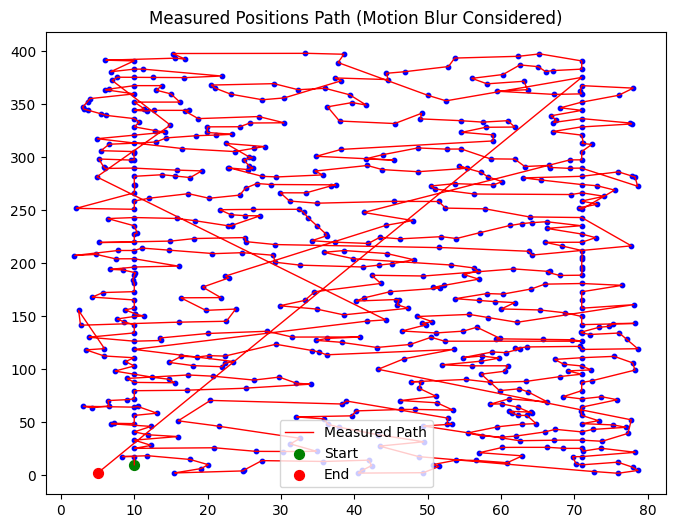

Total unique measured points along the path in step0: 17847
All anchor number is 648
PSNR between the final reconstruction and the true image: 22.235608046776516 dB
PSNR between the initial reconstruction and the true image: 17.78245000996486 dB


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/4s/3p31gpzn0sq_bdjm3d8dq_500000gn/T/ipykernel_7246/109759503.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  anchor_np = np.array(anchor)


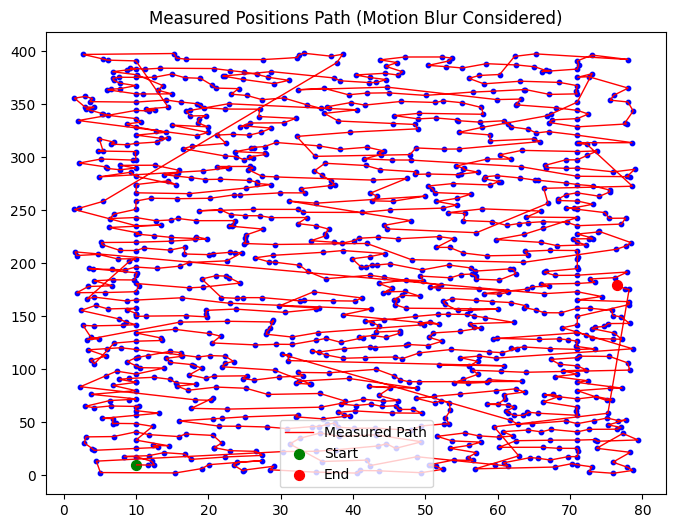

Total unique measured points along the path in step1: 22823
All anchor number is 1148
PSNR between the final reconstruction and the true image: 25.30805039733576 dB
PSNR between the initial reconstruction and the true image: 17.78245000996486 dB


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/4s/3p31gpzn0sq_bdjm3d8dq_500000gn/T/ipykernel_7246/109759503.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  anchor_np = np.array(anchor)


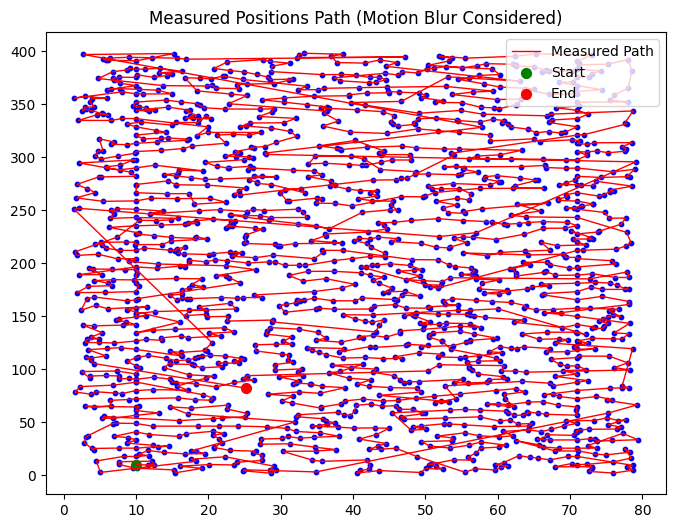

Total unique measured points along the path in step2: 26788
All anchor number is 1648
PSNR between the final reconstruction and the true image: 26.38525006345268 dB
PSNR between the initial reconstruction and the true image: 17.78245000996486 dB


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/4s/3p31gpzn0sq_bdjm3d8dq_500000gn/T/ipykernel_7246/109759503.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  anchor_np = np.array(anchor)


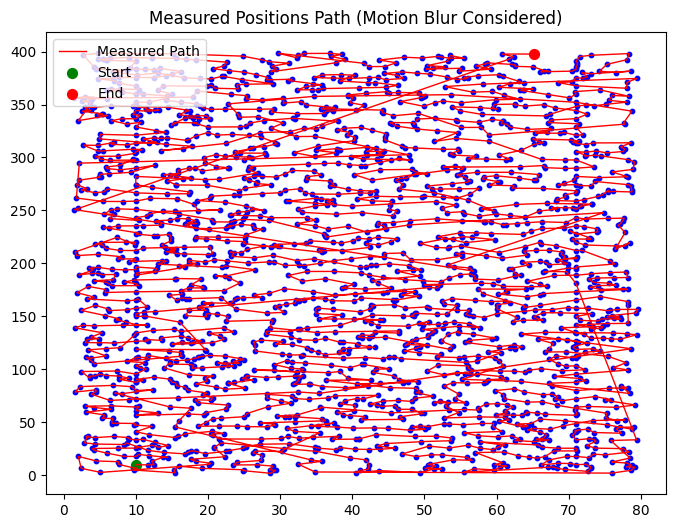

Total unique measured points along the path in step3: 30458
All anchor number is 2148
PSNR between the final reconstruction and the true image: 26.98817350880227 dB
PSNR between the initial reconstruction and the true image: 17.78245000996486 dB


In [6]:
measurement_configs = configs.FlyScanSimulationConfig(
    sample_params=sample_params,  # Use the defined spatial sample parameters
    setup_params=setup_params,  # Use the defined experimental setup parameters
    step_size_for_integration_nm=0.02,  # Step size for integration in nanometers
)
# Set up the simulator
simulator = measurement.FlyScanSingleValueSimulationMeasurement(measurement_configs)


values = init_vals
points = init_points # all points on the path
anchor = torch.tensor(anchor)
for step in range(4):
    optimized_scan_points, nn_inds = optimize_scan_points(points, values, xi, reconstructor, 500)
    anchor = torch.cat((anchor, torch.tensor(optimized_scan_points))) # add new 500 points to the anchor
    
    # save the points from last step
    pre_points = points
    pre_values = values
    
    # Calculate the distance matrix for the all optimized scan points (anchor)
    dist_matrix = distance_matrix(anchor, anchor)
    
    # Define start point and get the TSP path using nearest neighbor heuristic
    start_point = 0
    tsp_path = nearest_neighbor_tsp(start_point, dist_matrix)
    
    # Reorder the optimized scan points according to the TSP path
    ordered_scan_points = [anchor[i] for i in tsp_path]

    # Use simulator's measure method to simulate the scan with motion blur
    # ordered_scan_points are the list of vertices (waypoints)
    measured_values = simulator.measure(ordered_scan_points)  # This returns I_hats for this step only
    measured_positions = simulator.measured_positions  # This returns r_hats for this step only

    measured_positions_np = np.array(measured_positions)

    anchor_np = np.array(anchor)
    # Plot the measured path
    plt.figure(figsize=(8, 6))
    # Plot the measured TSP path (with motion blur considered)
    plt.plot(measured_positions_np[:, 0], measured_positions_np[:, 1], 'r-', lw=1, label='Measured Path')
    # Plot each point from the original optimized scan points
    for i, (x, y) in enumerate(anchor):
        plt.scatter(x, y, color='blue', s=10)
    # Add start and end labels
    plt.scatter(anchor[start_point][0], anchor[start_point][1], color='green', s=50, label='Start')
    plt.scatter(anchor[tsp_path[-1]][0], anchor[tsp_path[-1]][1], color='red', s=50, label='End')
    # Add title and legend
    plt.title('Measured Positions Path (Motion Blur Considered)')
    plt.legend()
    plt.show()
    
    # Print the number of unique points along the path (measured positions)
    total_points_in_path = len(measured_positions)
    print(f"Total unique measured points along the path in step{ step}: {total_points_in_path}")
    print(f'All anchor number is {len(anchor)}')
    
    # Combine the initial points and the measured scan points into one final set of points
    points_final = torch.tensor(measured_positions)
    values_final = torch.tensor(measured_values)


    points = points_final
    values = values_final

    
    # Perform the final reconstruction using the combined points and values
    recon_final = reconstructor.reconstruct_idw_torch(points_final, values_final, xi=xi, n_neighbors=30, power=2)
    # Convert the reconstruction to a NumPy array for visualization and PSNR calculation
    recon_final_np = recon_final.detach().numpy().reshape(meshgrids_dense[0].shape)
    
    # Calculate the distortion between the reconstructed image and the true probe image
    distortion_final = calculate_distortion(recon_final_np, probe_image)
    
    # Compute the PSNR between the final reconstruction and the true probe image
    psnr_value = psnr(probe_image, recon_final_np, data_range=probe_image.max() - probe_image.min())
    print(f"PSNR between the final reconstruction and the true image: {psnr_value} dB")
    
    psnr_value = psnr(probe_image, initial_recon, data_range=probe_image.max() - probe_image.min())
    print(f"PSNR between the initial reconstruction and the true image: {psnr_value} dB")

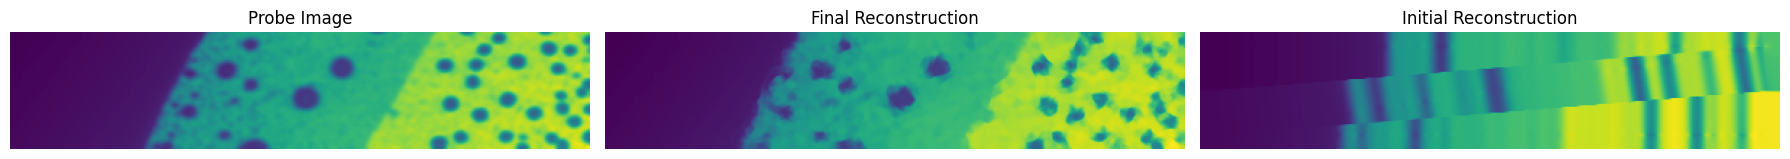

In [7]:
# Create a figure with 3 subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjusted size

# Show the original probe image for comparison
axs[0].imshow(probe_image)
axs[0].set_title("Probe Image")
axs[0].axis('off')

# Visualize the final reconstruction
axs[1].imshow(recon_final_np)
axs[1].set_title("Final Reconstruction")
axs[1].axis('off')


# Visualize the initial reconstruction
axs[2].imshow(initial_recon)
axs[2].set_title("Initial Reconstruction")
axs[2].axis('off')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with all three plots in one row
plt.show()


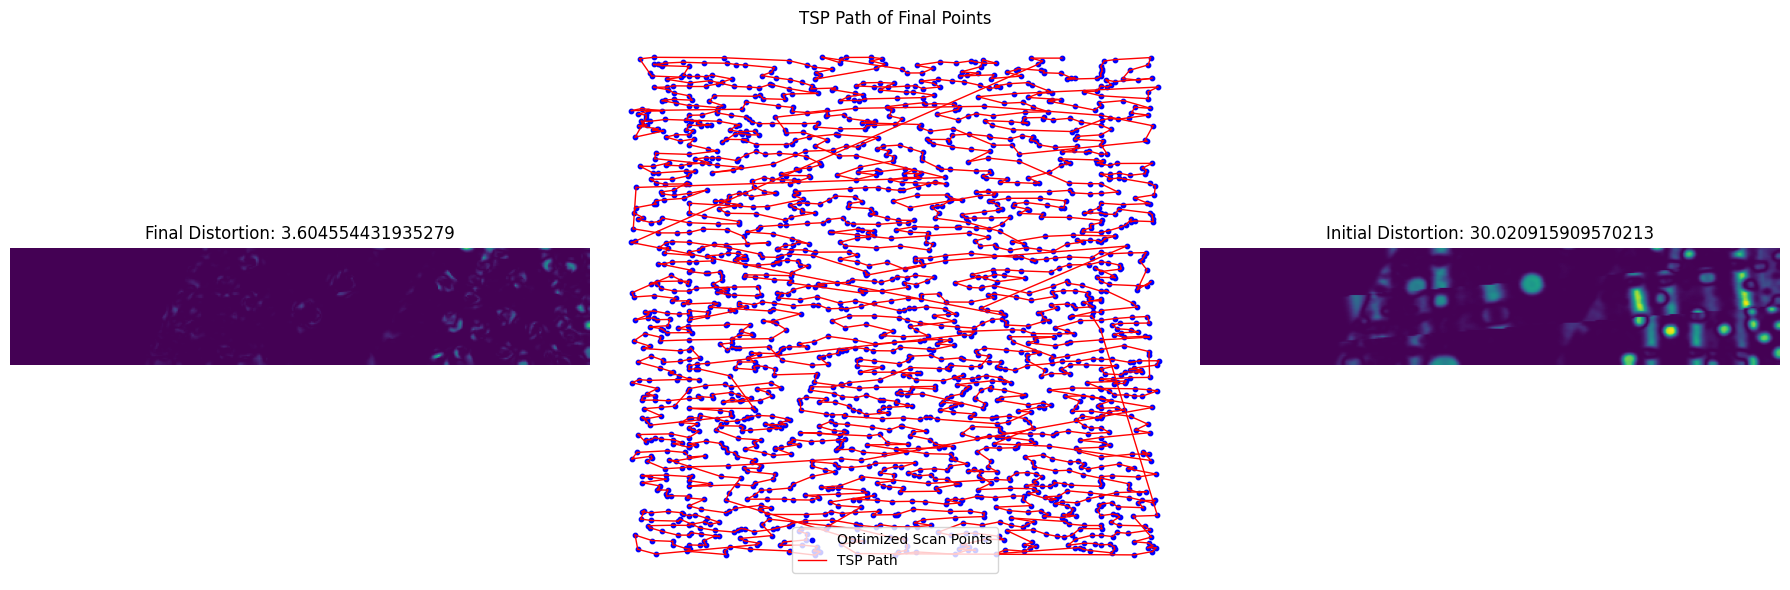

In [8]:
# Create a figure with 3 subplots in one row
points_final_np = points_final.detach().numpy()
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjusted size

# Calculate and visualize the final distortion
axs[0].imshow(distortion_final)
axs[0].set_title(f"Final Distortion: {np.sum(distortion_final)}")
axs[0].axis('off')


# Plot 2: TSP Path of Final Points (Just the TSP Path connecting optimized points)
# Plot the optimized scan points
for i, (x, y) in enumerate(anchor):
    axs[1].scatter(x, y, color='blue', s=10, label='Optimized Scan Points' if i == 0 else "")

# Plot the TSP path connecting the optimized scan points
for i in range(len(tsp_path) - 1):
    x_vals = [anchor[tsp_path[i]][0], anchor[tsp_path[i+1]][0]]
    y_vals = [anchor[tsp_path[i]][1], anchor[tsp_path[i+1]][1]]
    axs[1].plot(x_vals, y_vals, 'r-', lw=1, label='TSP Path' if i == 0 else "")

# Add title and legend to the second plot
axs[1].set_title("TSP Path of Final Points")
axs[1].legend()
axs[1].axis('off')


# Visualize the initial distortion
axs[2].imshow(distortion_before)
axs[2].set_title(f"Initial Distortion: {np.sum(distortion_before)}")
axs[2].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with all three plots in one row
plt.show()